In [8]:
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score,precision_score,accuracy_score,classification_report,roc_auc_score,confusion_matrix,roc_curve,auc
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from pyod.models.auto_encoder import AutoEncoder
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

In [9]:
df = pd.read_csv('data_cleaned.csv')

## Data Preprocessing for Training

In [3]:
# Data Preprocessing
df_normal = df[df['label'] == 0]
df_anomalous = df[df['label'] == 1]
df_normal = df_normal.drop(columns=['label'])
df_anomalous = df_anomalous.drop(columns=['label'])
# Data Distribution
print(f"Normal: {len(df_normal)}, Anomalous: {len(df_anomalous)}")

Normal: 569877, Anomalous: 20663


## Training the Model

- **K-fold cross-validation** was used to ensure the model was trained on different subsets of the data. Since only a subset of the normal class was used for testing, relying on a single split might not provide the most reliable results. K-fold cross-validation helps mitigate this issue by training the model across multiple data folds, leading to a more robust evaluation.

In [ ]:
# Create a KFold object with 10 splits
kf = KFold(n_splits=10, shuffle=True, random_state=42)
# Initialize an empty list to store the results
results = []
all_y_test = []
all_y_pred = []
# Iterate through the folds
for train_index, test_index in kf.split(df_normal):
    # Split the data into training and test sets
    X_train, X_test = df_normal.iloc[train_index], df_normal.iloc[test_index]
    y_test = np.full(len(X_test), 0)
    # add anomalous data to the test set
    X_test = pd.concat([X_test, df_anomalous])
    y_test = np.concatenate([y_test, np.full(len(df_anomalous), 1)])
    
    # Train the AutoEncoder model
    model = AutoEncoder(batch_size=2048)
    model.fit(X_train)
    
    # Predict the labels for the test set
    y_pred = model.predict(X_test)
    
    # Calculate the F1 score
    f1 = f1_score(y_test, y_pred, pos_label=1)
    precision = precision_score(y_test, y_pred, pos_label=1)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Append the results to the list
    results.append({
        'f1': f1,
        'precision': precision,
        'accuracy': accuracy
    })
    
    # Collect for final classification report
    all_y_test.extend(y_test)
    all_y_pred.extend(y_pred)
    
print(f"F1 Score: {np.mean([result['f1'] for result in results])}")
print(f"Precision: {np.mean([result['precision'] for result in results])}")
print(f"Accuracy: {np.mean([result['accuracy'] for result in results])}")
print(f"Classification Report: {classification_report(all_y_test, all_y_pred)}")

Training: 100%|██████████| 10/10 [04:59<00:00, 29.96s/it]


F1 Score: 0.42177479773741827
Precision: 0.552834069608279
Accuracy: 0.751241133808848
Classification Report:               precision    recall  f1-score   support

           0       0.79      0.90      0.84    569877
           1       0.55      0.34      0.42    206630

    accuracy                           0.75    776507
   macro avg       0.67      0.62      0.63    776507
weighted avg       0.73      0.75      0.73    776507



## Hyperparameter Tuning

In [ ]:
def objective(trial):
    # Suggest hyperparameters for AutoEncoder
    params = {
        'contamination': trial.suggest_float('contamination', 0.1, 0.5, step=0.1),
        'lr': trial.suggest_float('lr', 1e-5, 1e-2, log=True),
        'epoch_num': trial.suggest_int('epoch_num', 5, 50, step=5),
        'batch_size': trial.suggest_categorical('batch_size', [2048, 4096]),
        'optimizer_name': trial.suggest_categorical('optimizer_name', ['adam', 'sgd']),
        'hidden_neuron_list': [
            trial.suggest_int('hidden1', 16, 128, step=16),
            trial.suggest_int('hidden2', 8, 64, step=8),
        ],
        'hidden_activation_name': trial.suggest_categorical('hidden_activation_name', ['relu', 'leaky_relu', 'tanh']),
        'batch_norm': trial.suggest_categorical('batch_norm', [True, False]),
        'dropout_rate': trial.suggest_float('dropout_rate', 0.0, 0.5, step=0.1),
        'verbose': 0  # Silence training output during optimization
    }
    
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    f1_scores = []
    precisions = []
    accuracies = []
    
    for train_index, test_index in kf.split(df_normal):
        # Data preparation
        X_train = df_normal.iloc[train_index]
        X_test_normal = df_normal.iloc[test_index]
        
        # Create test set with anomalies
        X_test = pd.concat([X_test_normal, df_anomalous])
        y_test = np.concatenate([np.zeros(len(X_test_normal)), 
                               np.ones(len(df_anomalous))])
        
        # Initialize and train AutoEncoder
        model = AutoEncoder(
            **params,
            preprocessing=True,
            random_state=42
        )
        
        model.fit(X_train)
        
        # Get anomaly scores
        scores = model.decision_function(X_test)
        
        # Predict labels (1 for anomalies, 0 for normal)
        # Using contamination to determine threshold
        pred_labels = (scores > model.threshold_).astype(int)
        
        # Calculate metrics
        f1_scores.append(f1_score(y_test, pred_labels))
        precisions.append(precision_score(y_test, pred_labels))
        accuracies.append(accuracy_score(y_test, pred_labels))
    
    # Calculate mean metrics across folds
    avg_f1 = np.mean(f1_scores)
    avg_precision = np.mean(precisions)
    avg_accuracy = np.mean(accuracies)
    
    # Return sum of metrics for optimization
    return avg_f1 + avg_precision + avg_accuracy

# Create and run Optuna study
study = optuna.create_study(direction='maximize', storage='sqlite:///autoencoder_IEEE.db', load_if_exists=True, study_name="AutoEncoder_IEEE")
study.optimize(objective, n_trials=30)


# Best parameters
print("Best parameters:", study.best_params)
print(f"Best value (F1 + Precision + Accuracy): {study.best_value}")

[I 2025-04-05 12:21:52,112] Using an existing study with name 'AutoEncoder_IEEE' instead of creating a new one.


Best parameters: {'contamination': 0.1, 'lr': 0.002160246257852175, 'epoch_num': 40, 'batch_size': 2048, 'optimizer_name': 'adam', 'hidden1': 128, 'hidden2': 64, 'hidden_activation_name': 'relu', 'batch_norm': False, 'dropout_rate': 0.0}
Best value (F1 + Precision + Accuracy): 1.7942782774271704


In [ ]:
# Final evaluation with best parameters
best_params = study.best_params.copy()
best_params['verbose'] = 1  # Enable progress output for final training
best_params['hidden_neuron_list'] = [best_params.pop('hidden1'), best_params.pop('hidden2')]
# Initialize metrics storage
final_results = []
all_y_test = []
all_y_pred = []

kf = KFold(n_splits=10, shuffle=True, random_state=42)
for train_index, test_index in kf.split(df_normal):
    # Data preparation
    X_train = df_normal.iloc[train_index]
    X_test_normal = df_normal.iloc[test_index]
    
    # Create test set with anomalies
    X_test = pd.concat([X_test_normal, df_anomalous])
    y_test = np.concatenate([np.zeros(len(X_test_normal)), 
                           np.ones(len(df_anomalous))])

    # Training with best parameters
    model = AutoEncoder(**best_params)
    model.fit(X_train)

    # Get predictions
    scores = model.decision_function(X_test)
    y_pred = (scores > model.threshold_).astype(int)

    # Store results
    final_results.append({
        'f1': f1_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'accuracy': accuracy_score(y_test, y_pred)
    })
    
    # Collect for final classification report
    all_y_test.extend(y_test)
    all_y_pred.extend(y_pred)

# Print final metrics
print(f"\nFinal F1 Score: {np.mean([r['f1'] for r in final_results])}")
print(f"Final Precision: {np.mean([r['precision'] for r in final_results])}")
print(f"Final Accuracy: {np.mean([r['accuracy'] for r in final_results])}")
print("\nClassification Report:")
print(classification_report(all_y_test, all_y_pred))

Training: 100%|██████████| 40/40 [15:59<00:00, 24.00s/it]



Final F1 Score: 0.45735205417340874
Final Precision: 0.5769497812682894
Final Accuracy: 0.7608701684969938

Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.90      0.85    569877
         1.0       0.58      0.38      0.46    206630

    accuracy                           0.76    776507
   macro avg       0.69      0.64      0.65    776507
weighted avg       0.74      0.76      0.74    776507



## Trainging and Validation difference in prediction

In [4]:
study = optuna.create_study(direction='maximize', storage='sqlite:///autoencoder_IEEE.db', load_if_exists=True, study_name="AutoEncoder_IEEE")

[I 2025-04-09 19:30:12,994] Using an existing study with name 'AutoEncoder_IEEE' instead of creating a new one.


In [5]:
best_params = study.best_params.copy()
best_params['verbose'] = 1
best_params['hidden_neuron_list'] = [best_params.pop('hidden1'), best_params.pop('hidden2')]

In [6]:
# Storage variables
train_scores = []
test_scores = []
test_labels = []

all_y_test = []
all_y_pred = []
all_y_pred_train = []
all_y_test_train = []

# Store plot data for first 5 folds
fold_plots_data = []

# Create a KFold object with 10 splits
kf = KFold(n_splits=10, shuffle=True, random_state=42)
n = 0

# Iterate through the folds
for train_index, test_index in kf.split(df_normal):
    n += 1
    
    # Data preparation
    X_train = df_normal.iloc[train_index]
    X_test_normal = df_normal.iloc[test_index]
    
    # Create test set with anomalies
    X_test = pd.concat([X_test_normal, df_anomalous])
    y_test = np.concatenate([np.zeros(len(X_test_normal)), np.ones(len(df_anomalous))])
    
    # Train model
    model = AutoEncoder(**best_params)
    model.fit(X_train)
    
    # Get scores
    train_score = model.decision_function(X_train)
    test_score = model.decision_function(X_test)
    
    # Store aggregate scores
    train_scores.extend(train_score)
    test_scores.extend(test_score)
    test_labels.extend(y_test)  # Already contains 0s and 1s in order
    
    # Get predictions
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    
    # Store classification data
    all_y_test.extend(y_test)
    all_y_pred.extend(y_pred)
    all_y_pred_train.extend(y_pred_train)
    all_y_test_train.extend([0]*len(X_train))
    
    # Store plot data for first 5 folds
    if n <= 5:
        fold_data = {
            'train_scores': train_score.tolist(),
            'train_pred': y_pred_train.tolist(),
            'test_scores': test_score.tolist(),
            'test_actual': y_test.tolist(),
            'test_pred': y_pred.tolist()
        }
        fold_plots_data.append(fold_data)

# Store aggregated histogram data
histogram_data = {
    'train_scores': train_scores,
    'test_scores': test_scores,
    'test_labels': test_labels
}

# Store classification reports
test_clf_report = classification_report(all_y_test, all_y_pred, output_dict=True)
train_clf_report = classification_report(all_y_test_train, all_y_pred_train, output_dict=True)

# Combine all stored results
stored_results = {
    'fold_plots_data': fold_plots_data,
    'histogram_data': histogram_data,
    'classification_reports': {
        'test': test_clf_report,
        'train': train_clf_report
    }
}

Training: 100%|██████████| 40/40 [14:11<00:00, 21.28s/it]
/home/pranav/anaconda3/envs/bytive/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/pranav/anaconda3/envs/bytive/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/pranav/anaconda3/envs/bytive/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

In [7]:
import pickle
# Save the results to a file
with open('autoencoder_results.pkl', 'wb') as f:
    pickle.dump(stored_results, f)

In [4]:
import pickle
stored_results = pickle.load(open('autoencoder_results.pkl', 'rb'))

In [5]:
def plot_fast_fold(fold_data, fold_num, subsample_factor=10,subsample_factor_train =100):
    """Plot fold data with original styling but optimized rendering"""
    plt.figure(figsize=(12, 6))
    
    # Training data (always blue)
    train_scores = np.array(fold_data['train_scores'][::subsample_factor_train])
    train_pred = np.array(fold_data['train_pred'][::subsample_factor_train])
    
    # Split training into predicted normal/anomalous
    train_normal = train_pred == 0
    train_anomalies = train_pred == 1
    
    # Plot training normals (circles)
    plt.scatter(np.where(train_normal)[0], train_scores[train_normal],
                color='blue', marker='o', alpha=0.5, s=10, label='Train Normal')
    
    # Plot training anomalies (crosses)
    if np.any(train_anomalies):
        plt.scatter(np.where(train_anomalies)[0], train_scores[train_anomalies],
                    color='blue', marker='x', alpha=0.8, s=30, label='Train Anomalies')

    # Test data
    test_scores = np.array(fold_data['test_scores'][::subsample_factor])
    test_actual = np.array(fold_data['test_actual'][::subsample_factor])
    test_pred = np.array(fold_data['test_pred'][::subsample_factor])
    offset = len(train_scores)
    
    # Create test indices
    test_indices = np.arange(offset, offset + len(test_scores))
    
    # Split test data into 4 groups
    normal_normal = (test_actual == 0) & (test_pred == 0)
    normal_anomaly = (test_actual == 0) & (test_pred == 1)
    anomaly_anomaly = (test_actual == 1) & (test_pred == 1)
    anomaly_normal = (test_actual == 1) & (test_pred == 0)
    
    # Plot test normal-correct (green circles)
    plt.scatter(test_indices[normal_normal], test_scores[normal_normal],
                color='green', marker='o', alpha=0.5, s=10, label='Test Normal Correct')
    
    # Plot test normal-incorrect (green x)
    if np.any(normal_anomaly):
        plt.scatter(test_indices[normal_anomaly], test_scores[normal_anomaly],
                    color='green', marker='x', alpha=0.8, s=30, label='Test Normal Wrong')
    
    # Plot test anomaly-correct (red x)
    if np.any(anomaly_anomaly):
        plt.scatter(test_indices[anomaly_anomaly], test_scores[anomaly_anomaly],
                    color='red', marker='x', alpha=0.8, s=30, label='Test Anomaly Correct')
    
    # Plot test anomaly-incorrect (red circles)
    if np.any(anomaly_normal):
        plt.scatter(test_indices[anomaly_normal], test_scores[anomaly_normal],
                    color='red', marker='o', alpha=0.5, s=10, label='Test Anomaly Wrong')

    plt.title("Anomaly Scores (Actual vs Predicted)")
    plt.xlabel("Sample Index")
    plt.ylabel("Score")
    plt.grid(True)

    # Create simplified legend
    handles = [
        plt.Line2D([], [], color='blue', marker='o', linestyle='', label='Train Normal'),
        plt.Line2D([], [], color='blue', marker='x', linestyle='', label='Train Anomaly'),
        plt.Line2D([], [], color='green', marker='o', linestyle='', label='Normal'),
        plt.Line2D([], [], color='green', marker='x', linestyle='', label='Normal Pred Wrong'),
        plt.Line2D([], [], color='red', marker='x', linestyle='', label='Anomaly'),
        plt.Line2D([], [], color='red', marker='o', linestyle='', label='Anomaly Pred Wrong')
    ]
    plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

def plot_fast_histograms(hist_data):
    """Histogram plot with original color scheme"""
    plt.figure(figsize=(10, 6))
    
    sns.histplot(hist_data['train_scores'], color='blue', 
                 label='Train (Normal)', kde=True, element='step')
    sns.histplot([s for s, l in zip(hist_data['test_scores'], hist_data['test_labels']) if l == 0],
                 color='green', label='Test Normal', kde=True, element='step')
    sns.histplot([s for s, l in zip(hist_data['test_scores'], hist_data['test_labels']) if l == 1],
                 color='red', label='Test Anomalous', kde=True, element='step')
    
    plt.title('Aggregated Anomaly Score Distributions (Original Style)')
    plt.legend()
    plt.ylim(0, 10000)
    plt.xlim(0, 5)
    plt.show()

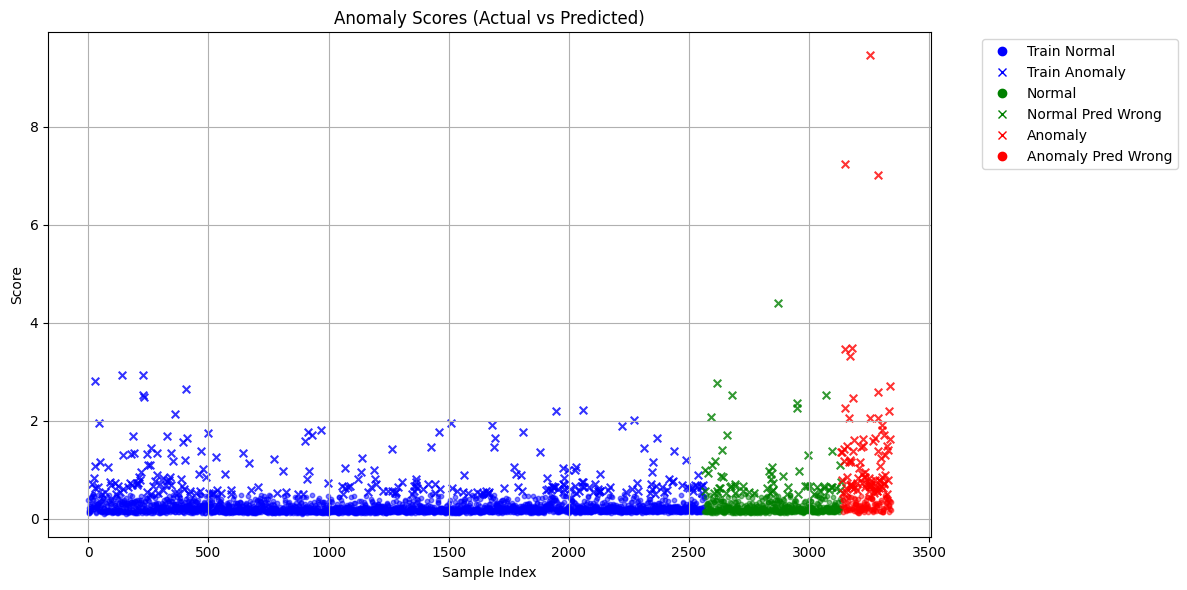

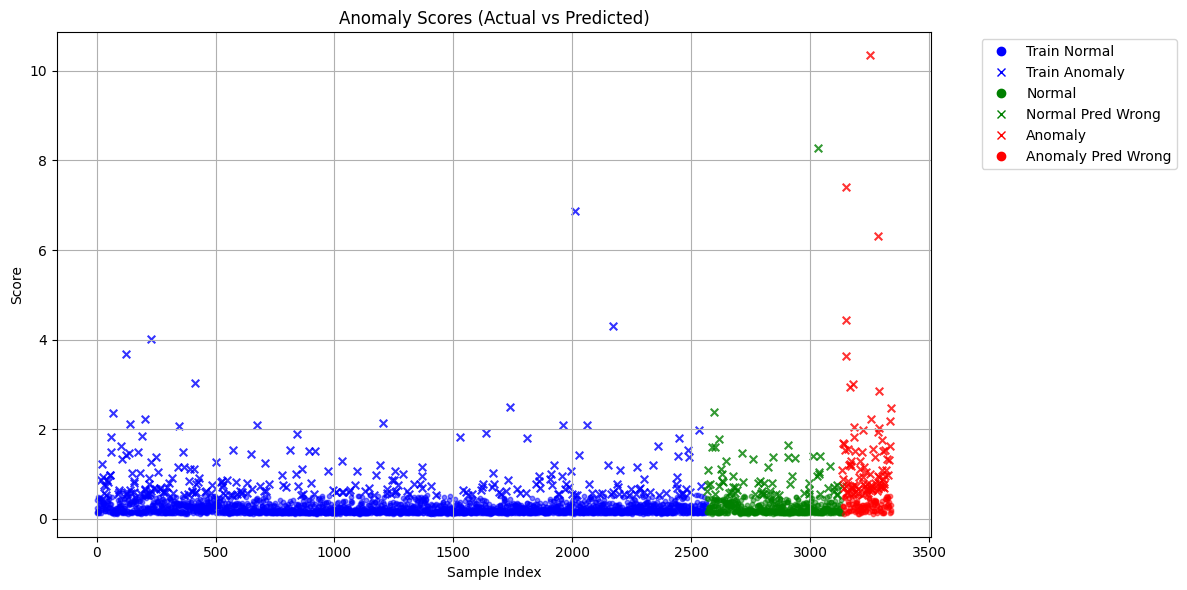

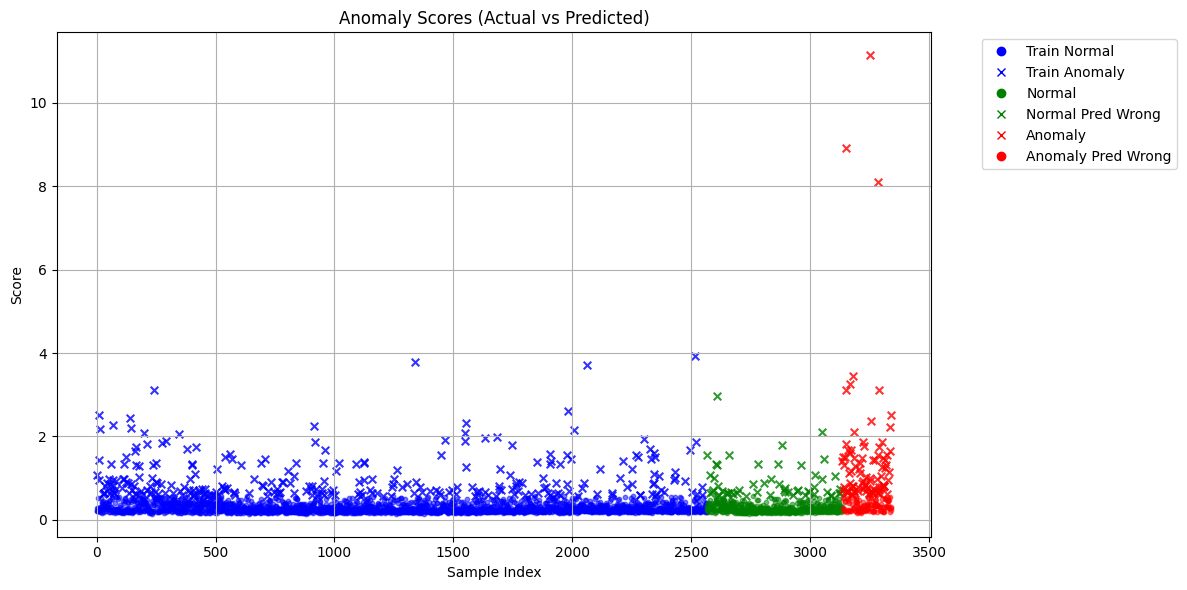

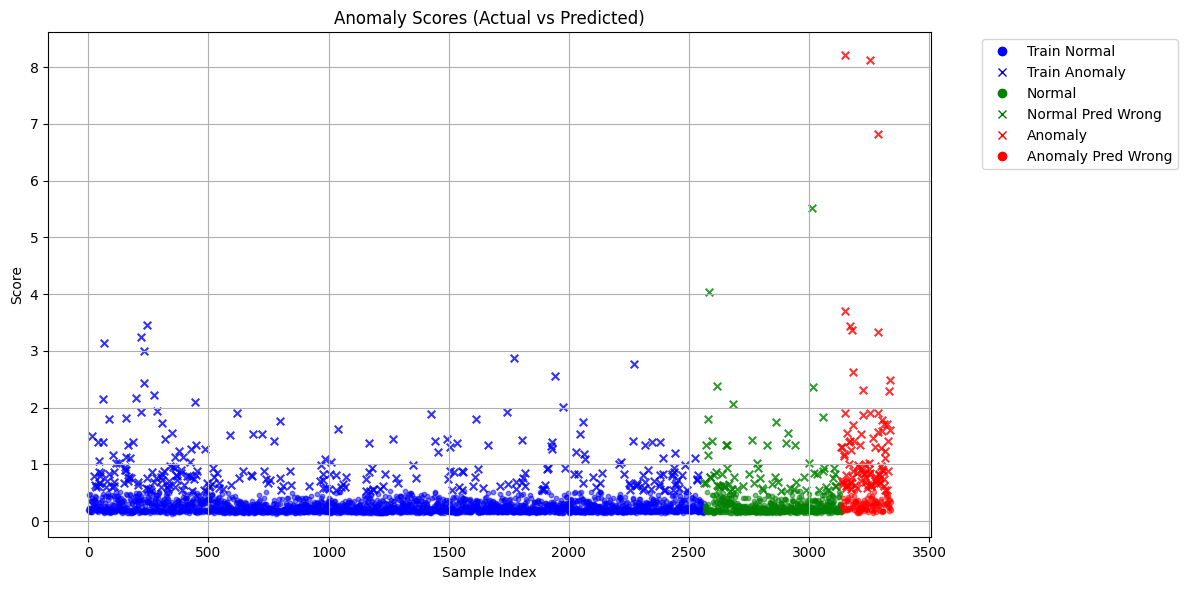

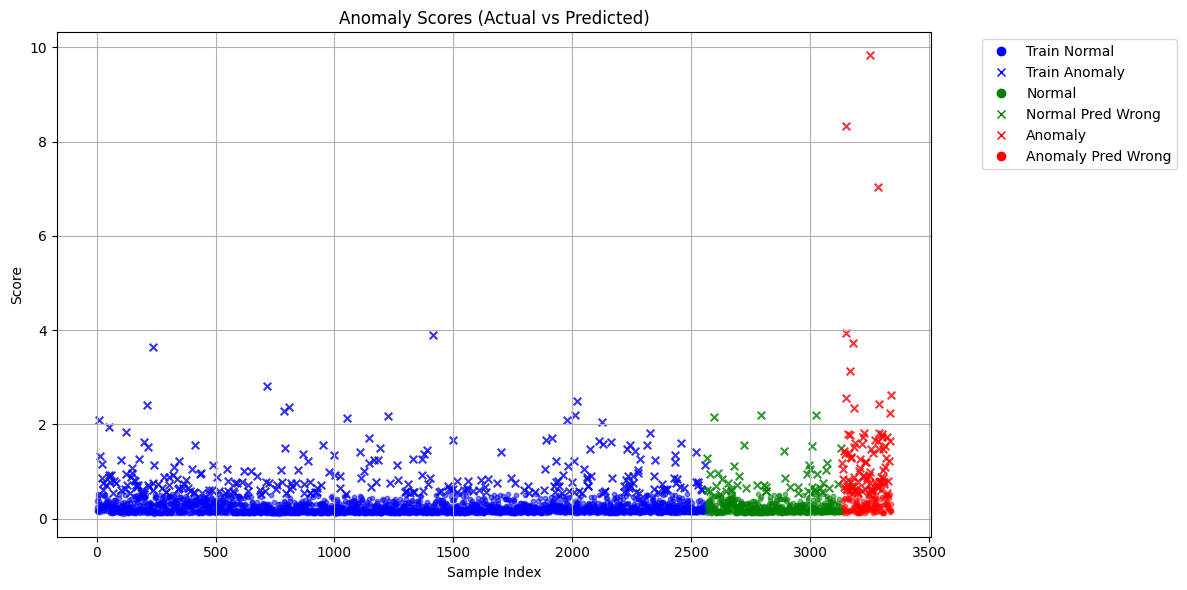

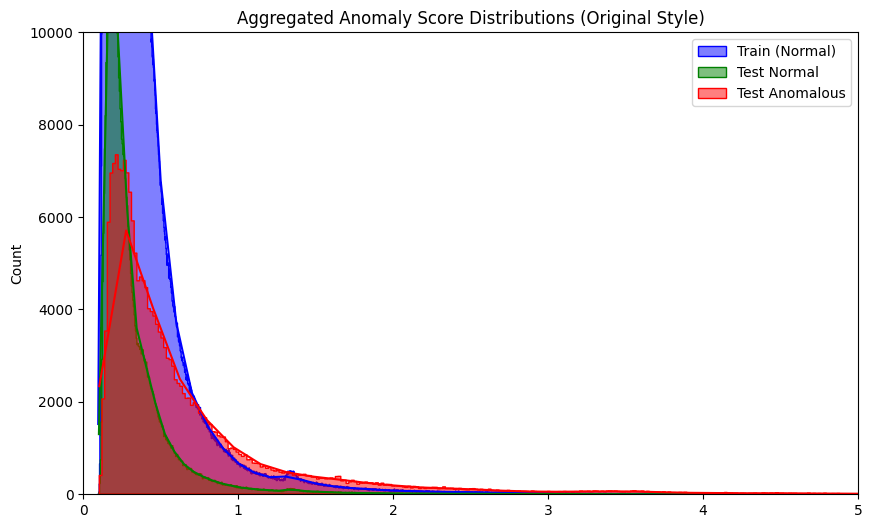

In [13]:
# Plot first 5 folds with subsampling
for i, fold_data in enumerate(stored_results['fold_plots_data'][:5]):
    plot_fast_fold(fold_data, i+1, subsample_factor=100,subsample_factor_train=200)  # Adjust factor as needed

# Plot optimized histograms
plot_fast_histograms(stored_results['histogram_data'])

In [7]:
stored_results['classification_reports']['test']

{'0.0': {'precision': 0.7997534505223572,
  'recall': 0.8993484558948686,
  'f1-score': 0.8466320096603515,
  'support': 569877.0},
 '1.0': {'precision': 0.5771918444369094,
  'recall': 0.37895271741760633,
  'f1-score': 0.45752164818342234,
  'support': 206630.0},
 'accuracy': 0.7608701531344856,
 'macro avg': {'precision': 0.6884726474796333,
  'recall': 0.6391505866562375,
  'f1-score': 0.6520768289218869,
  'support': 776507.0},
 'weighted avg': {'precision': 0.7405293808546838,
  'recall': 0.7608701531344856,
  'f1-score': 0.7430889971801319,
  'support': 776507.0}}